# Deterministic optimisation (using the fluid model)

Here we optimise over several deterministic objective functions evaluated using the fluid flow model. 

We start by giving an illustrative example of the dynamics of the unsheltered queue $u_t$ given by our fluid model, given inputs for $X_0, \mu_0$ and $\lambda_t, h_t, s_t$ for all $t \in \{1,...,T\}$ which we take directly from the simulation model of Singham et al (2023) (see right hand side of Fig 2 with 70% investment in housing).

In [1]:
import json
import fluid_flow_model as fl
import matplotlib.pyplot as plt
import math
import numpy as np

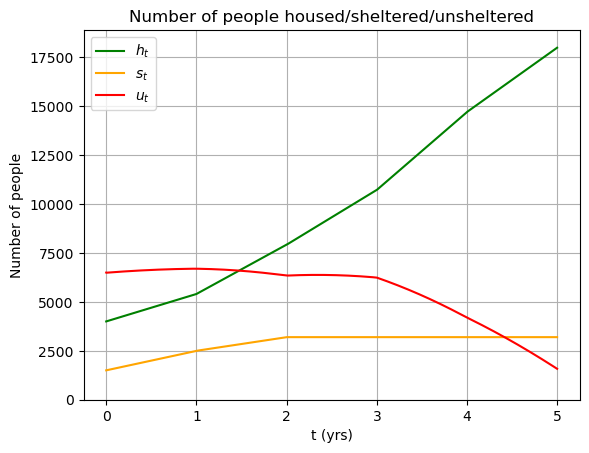

In [2]:
# Get data
with open('data_singham23.json') as json_file:
    data = json.load(json_file)

# Modelling horizonT_a is decision horizon, T_b is extra modelling horizon - here set to 0
T_a = 5*365
T_b = 0

# Modeling
model = fl.FluidFlowModel(data, data['solution'], T_a, T_b)
T = [i for i in range(T_a+T_b)]
model.analyse(T)

# Plotting
fig, ax = plt.subplots()
ymax = max(model.h + model.s + model.u)
x = [t/365 for t in range(T_a+T_b)]
ax.plot(x, model.h, color = 'green')
ax.plot(x, model.s, color = 'orange')
ax.plot(x, model.u, color = 'red')
ax.set(xlabel='t (yrs)', ylabel='Number of people',
       title='Number of people housed/sheltered/unsheltered')
ax.legend(["$h_t$", "$s_t$", "$u_t$"], loc="upper left")
ax.grid()
ax.set_ylim(0,ymax*1.05)
plt.show()

####  $\Phi_0$ : linear penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t) + c*E[sh(t)]])
    # s.t. total budget constraint
    #      annual minimum build constraint

As shown below, an optimal solution here would spend **all surplus budget in the first year**, on either housing or shelter.

In [3]:
import deterministic_optimisation as do

# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [10.0]*5 + [6.0]*5,
        'budget' : 200000000.0, # in dollars
        'costs_accomm' : {'housing' : 30000.0, 'shelter' : 10000.0}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'T_a' : 5*365, # in days: modelling and building
                    'T_b' : 5*365, # in days: extra modelling following all building
                    'model' : do.FluidModel}

------- Optimal solution -------
Housing capacity at end of each year: [4500.0, 5000.0, 5500.0, 6000.0, 6500.0]
Shelter capacity at the end of each year: [2000.0, 2500.0, 3000.0, 3500.0, 4000.0]
Optimal objective val: 22287.41


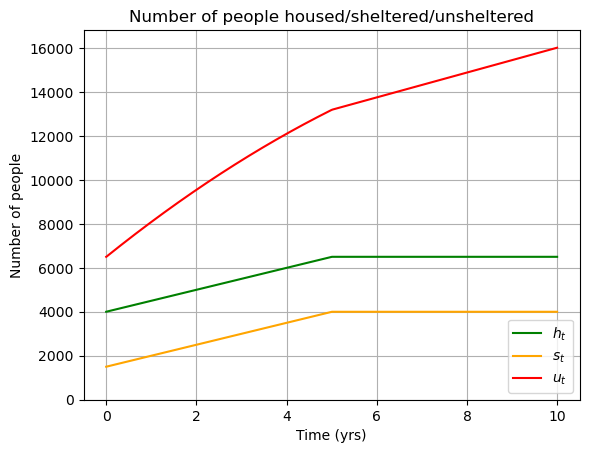

In [8]:
# Set up problem and solve
problem0 = do.Phi0(data, modeling_options, 'phi0', c=0.5)
problem0.solve('glpk')

####  $\Phi_1$ : quadratic penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint

Non-trivial solutions are obtained with a quadratic objective function which discourages the spending of all surplus budget on one type of accommodation and balances the unshelterd and sheltered queues. We note here that: 

* **Shelter** quickly reduces the unsheltered queue, at the expense of a large **sheltered** population.
* **Housing** gives long-term relief to the system, with an initial large **unsheltered** population.  

------- Optimal solution -------
Housing capacity at end of each year: [4725.73, 5440.78, 6147.28, 6846.73, 7540.21]
Shelter capacity at the end of each year: [5353.86, 6999.69, 8327.35, 9519.6, 10634.11]
Optimal objective val: 570282658.33


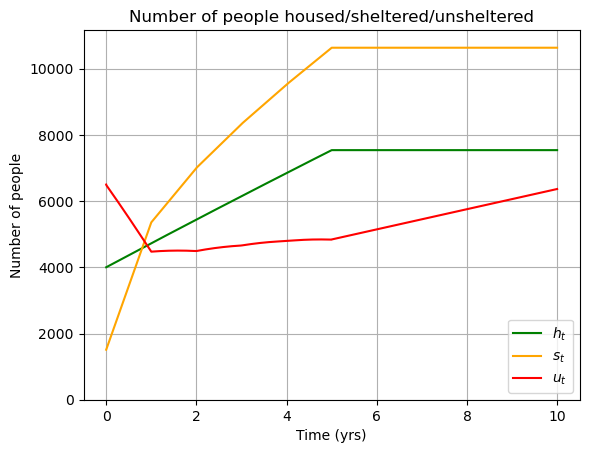

In [5]:
# Set up problem and solve
problem1 = do.Phi1(data, modeling_options, 'phi1', c=0.5)
problem1.solve('ipopt')

####  $\Phi_2$ : Add shape constraints
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      shape constraint on house building rate: positive and non-decreasing
    #      shape constraint on shelter building rate: positive and non-decreasing then negative. 

We here add shape constraints to reflect the fact that: 

* A five-year budget should be spread out across that horizon rather than being used predominantly in the first year.
* We would like the house building rate to at least stay the same over time, or even ramp up. 
* We would like to encourage a negative shelter build rate towards the end of the horizon to allow the 'conversion' of shelter to housing.

When optimising over the quadratic objective function, we find an optimal solution which has the following features: 

* A constant house building rate over the decision horizon. 
* An initial ramp up of shelter is able to bring the unshelterd queue down.
* Subsequent conversion of shelter to housing makes it affordable to build sufficient housing to obtain a service rate in the long run which is greater than the arrival rate of $2500 \text{ arrivals per year}$.
* The price to pay for conversion is an increased unsheltered population in the short term. 

------- Optimal solution -------
Housing capacity at end of each year: [4136.99, 4495.67, 5113.24, 6249.81, 8481.47]
Shelter capacity at the end of each year: [9351.53, 12102.03, 14641.58, 9023.18, 3854.6]
Optimal objective val: 570282658.33


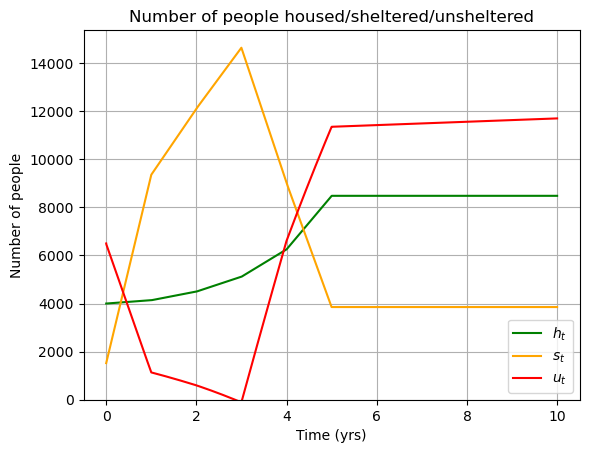

In [6]:
# Set up problem and solve
problem2 = do.Phi2(data, modeling_options, 'phi2', c=0.5, shelter_mode = 3)
problem2.solve('ipopt')

#### Comparison of results

In [7]:
import pandas as pd
data = [['$\Phi_0$']+['Housing']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem2.problem.costs_accomm['housing'])/(problem2.problem.budget)) + ')' for x in problem2.h_opt],
        ['']+['Shelter']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem2.problem.costs_accomm['shelter'])/(problem2.problem.budget)) + ')' for x in problem2.s_opt],
       ['$\Phi_1$']+['Housing']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem3.problem.costs_accomm['housing'])/(problem3.problem.budget)) + ')' for x in problem3.h_opt],
        ['']+['Shelter']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem3.problem.costs_accomm['shelter'])/(problem3.problem.budget)) + ')' for x in problem3.s_opt]]
df = pd.DataFrame(columns=['Problem','Building Type','Year 1','Year 2','Year 3','Year 4','Year 5'], data=data)
df.style.hide()

NameError: name 'problem3' is not defined